In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (11,6)
sns.set_style("whitegrid")


In [30]:
DATA_PATH = r"C:\Users\nandi\api_data_aadhar_demographic"

# Read all CSV files from folder
csv_files = glob.glob(os.path.join(DATA_PATH, "*.csv"))

print("CSV files found:", len(csv_files))

# Merge ALL CSVs into ONE dataframe
df = pd.concat(
    (pd.read_csv(file) for file in csv_files),
    ignore_index=True,
    sort=False
)

print("Total Rows:", df.shape[0])
print("Total Columns:", df.shape[1])
df.head()


CSV files found: 6
Total Rows: 2143400
Total Columns: 6


,date,state,district,pincode,demo_age_5_17,demo_age_17_
0,01-03-2025,Uttar Pradesh,Gorakhpur,273213,49,529
1,01-03-2025,Andhra Pradesh,Chittoor,517132,22,375
2,01-03-2025,Gujarat,Rajkot,360006,65,765
3,01-03-2025,Andhra Pradesh,Srikakulam,532484,24,314
4,01-03-2025,Rajasthan,Udaipur,313801,45,785


In [31]:
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
    .str.replace("-", "_")
)
df.head()


,date,state,district,pincode,demo_age_5_17,demo_age_17_
0,01-03-2025,Uttar Pradesh,Gorakhpur,273213,49,529
1,01-03-2025,Andhra Pradesh,Chittoor,517132,22,375
2,01-03-2025,Gujarat,Rajkot,360006,65,765
3,01-03-2025,Andhra Pradesh,Srikakulam,532484,24,314
4,01-03-2025,Rajasthan,Udaipur,313801,45,785


In [32]:
data_quality = pd.DataFrame({
    "dtype": df.dtypes,
    "missing_%": df.isnull().mean() * 100,
    "unique_values": df.nunique()
}).sort_values("missing_%", ascending=False)

data_quality


,dtype,missing_%,unique_values
date,object,0.0,95
state,object,0.0,65
district,object,0.0,983
pincode,int64,0.0,19742
demo_age_5_17,int64,0.0,614
demo_age_17_,int64,0.0,2668


In [33]:
df.drop_duplicates(inplace=True)

numeric_cols = df.select_dtypes(include=np.number).columns
categorical_cols = df.select_dtypes(include="object").columns

# Fill missing values
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

print("Cleaned Dataset Shape:", df.shape)


Cleaned Dataset Shape: (1598099, 6)


In [34]:
os.makedirs("diagrams", exist_ok=True)


In [35]:
if "age" in df.columns:
    plt.figure()
    sns.histplot(df["age"], bins=40, kde=True)
    plt.title("Age Distribution of Aadhaar Updates")
    plt.xlabel("Age")
    plt.ylabel("Count")

    plt.savefig("diagrams/01_age_distribution.png", dpi=300, bbox_inches="tight")
    plt.show()


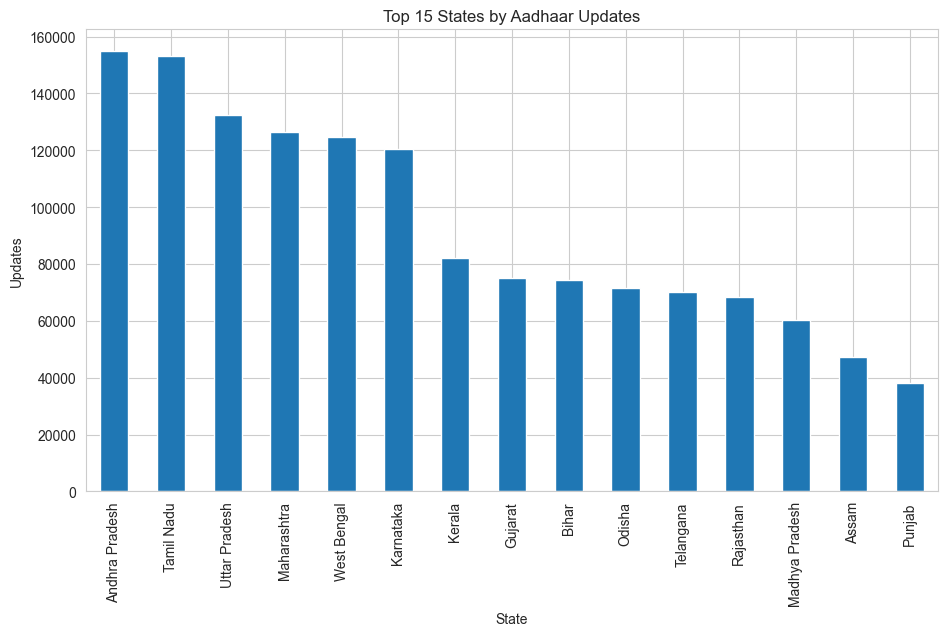

In [36]:
if "state" in df.columns:
    top_states = df["state"].value_counts().head(15)

    plt.figure()
    top_states.plot(kind="bar")
    plt.title("Top 15 States by Aadhaar Updates")
    plt.xlabel("State")
    plt.ylabel("Updates")

    plt.savefig("diagrams/02_state_updates.png", dpi=300, bbox_inches="tight")
    plt.show()


In [37]:
print(df.columns.tolist())


['date', 'state', 'district', 'pincode', 'demo_age_5_17', 'demo_age_17_']


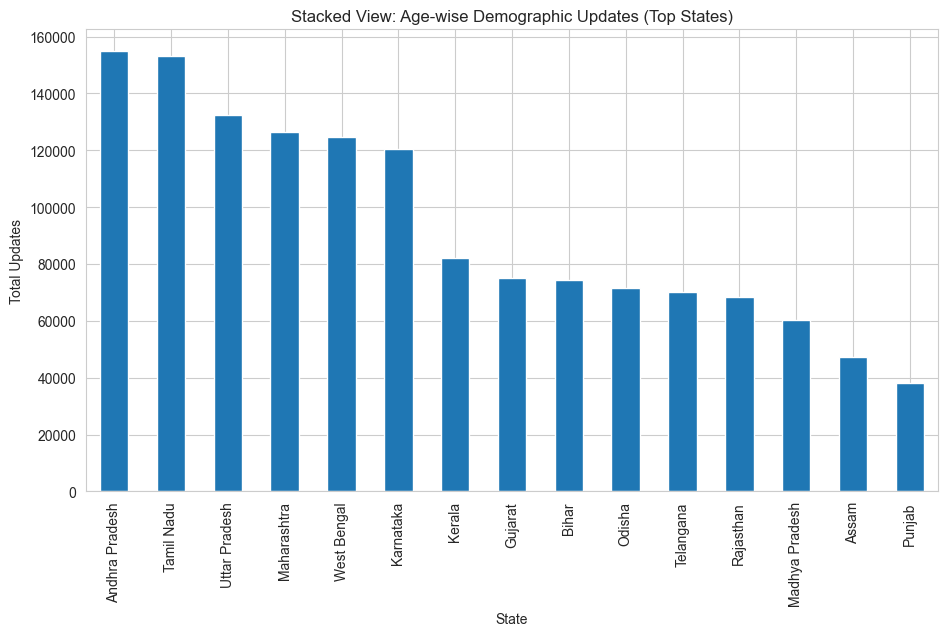

In [38]:
plt.figure()
top_states.plot(kind="bar", stacked=True)
plt.title("Stacked View: Age-wise Demographic Updates (Top States)")
plt.xlabel("State")
plt.ylabel("Total Updates")

plt.savefig("diagrams/03_stacked_age_updates.png", dpi=300, bbox_inches="tight")
plt.show()



In [39]:
df["date"].isna().sum()


0

<Figure size 1100x600 with 0 Axes>

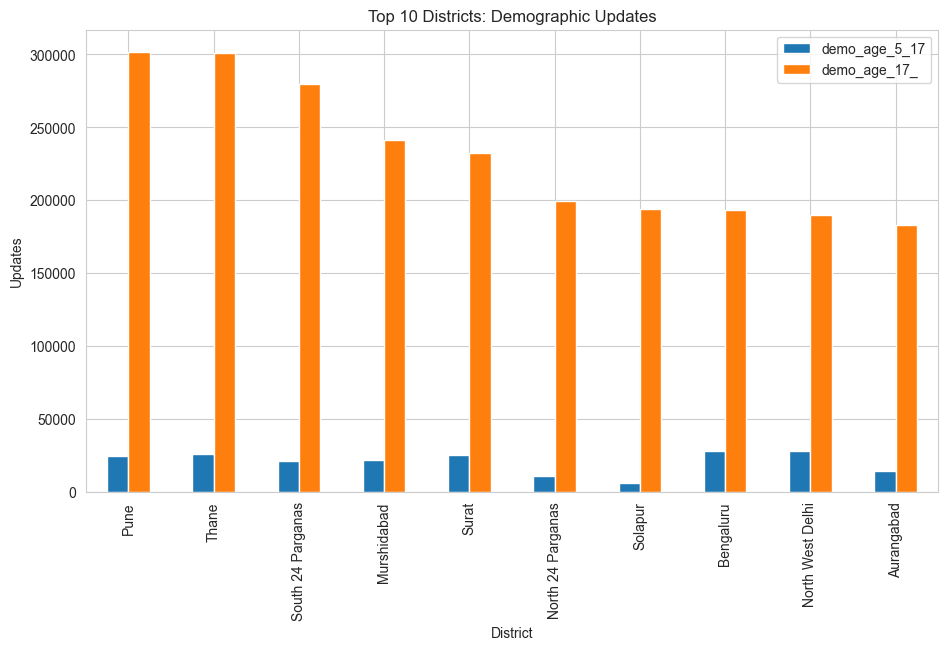

In [43]:
district_updates = df.groupby("district")[["demo_age_5_17", "demo_age_17_"]].sum()
top_districts = district_updates.sort_values("demo_age_17_", ascending=False).head(10)

plt.figure()
top_districts.plot(kind="bar")
plt.title("Top 10 Districts: Demographic Updates")
plt.xlabel("District")
plt.ylabel("Updates")

plt.savefig("diagrams/05_district_updates.png", dpi=300, bbox_inches="tight")
plt.show()

In [44]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[numeric_cols])

iso = IsolationForest(contamination=0.02, random_state=42)
df["anomaly"] = iso.fit_predict(scaled_data)

df["anomaly"].value_counts()



anomaly
 1    1566140
-1      31959
Name: count, dtype: int64

In [ ]:
plt.figure()
sns.scatterplot(
    x=df["date"],
    y=df["demo_age_17_"],
    hue=df["anomaly"],
    palette={1: "blue", -1: "red"}
)
plt.title("Anomaly Detection in Demographic Updates (17+ Age Group)")
plt.xlabel("Date")
plt.ylabel("Updates")

plt.savefig("diagrams/06_anomaly_detection.png", dpi=300, bbox_inches="tight")
plt.show()

